# Лабораторная работа №3 
## Моделирование работы системы ПВО

In [68]:
import numpy as np
from scipy.constants import g, pi
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [69]:
%matplotlib notebook
style = {'description_width': 'initial'}

In [70]:
A_button = widgets.FloatText(value = 0, description='Положение точки A', style = style)
U0_button = widgets.FloatText(value = 1000, description='Скорость ракеты', style = style)
U0__button = widgets.FloatText(value = 2000, description='Скорость противоракеты', style = style)
alpha_button = widgets.FloatText(value = pi/4, description='Угол старта ракеты', style = style)
err_button = widgets.FloatText(value = 0.01, description='Размер ошибки', style = style)
T1_button = widgets.IntText(value = 15, description='Время окончания измерений', style = style)
T0_button = widgets.IntText(value = 40, description='Время начала измерений', style = style)

In [89]:
display(A_button)
display(U0_button)
display(U0__button)
display(alpha_button)
display(err_button)
display(T1_button)
display(T0_button)

FloatText(value=0.0, description='Положение точки A', style=DescriptionStyle(description_width='initial'))

FloatText(value=1000.0, description='Скорость ракеты', style=DescriptionStyle(description_width='initial'))

FloatText(value=2000.0, description='Скорость противоракеты', style=DescriptionStyle(description_width='initia…

FloatText(value=0.7853981633974483, description='Угол старта ракеты', style=DescriptionStyle(description_width…

FloatText(value=0.01, description='Размер ошибки', style=DescriptionStyle(description_width='initial'))

IntText(value=15, description='Время окончания измерений', style=DescriptionStyle(description_width='initial')…

IntText(value=40, description='Время начала измерений', style=DescriptionStyle(description_width='initial'))

In [90]:
A_ = A_button.value
u0 = U0_button.value
alpha = alpha_button.value
err = err_button.value
T0 = T0_button.value
T1 = T1_button.value
u0_ = U0__button.value

### Уравнения движения тела брошенного под углом к горизонту:

$ x = x_0 + u_0cos(\alpha)t$

$y = y_0 + u_0sin(\alpha)t - \frac{gt^2}{2}$ 

$L = \frac{u_0^2sin(2\alpha)}{g}$

$t_{полета} = \frac{2u_0sin(\alpha)}{g} = 2t_{max}$  

In [91]:
flight_time = 2*u0*np.sin(alpha)/g
t = np.linspace(0, flight_time, 1000)
D = u0**2*np.sin(2*alpha)/g
C = 0.75*(D-A_)
x = lambda t, alpha1=alpha, x0=0, u0=u0: x0 + u0*np.cos(alpha1)*t
y = lambda t, alpha1=alpha, y0=0, u0=u0: y0 + u0*np.sin(alpha1)*t - (g*t**2)/2
te = np.linspace(15,T0,26)
xe = x(te)
ye = y(te)*(1+err*np.random.randn(26))
A = np.matrix([xe**2, xe, np.ones(26)]).T
koef = np.linalg.inv(A.T*A)*A.T*np.matrix(ye).T
#koef = np.linalg.lstsq(A, ye,rcond=None)[0]
#koef = np.matrix(koef).T

находим точку запуска решая полученное уравнение траектории ракеты

угол полета ракеты возмездия находим из уравнения полета тела



In [92]:
x0 = (-koef[1,0] + np.sqrt(koef[1,0]**2-4*koef[0,0]*koef[2,0]))/(2*koef[0,0])
alpha_ = np.arcsin((C-x0)*g/(u0_**2))/2

угол полета антиракеты найдем минимизируя предполагаемое расстояние, как функцию от времени и угла полета ракеты

In [93]:
f = lambda t: (x(t[0])-x(t[0]-T0, t[1], C, -1*u0_))**2+\
    (koef[0,0]*(x(t[0])**2)+koef[1,0]*x(t[0])+koef[2,0] -y(t[0]-T0, t[1], 0, u0_))**2
c = minimize(f,[T0+1,pi/4],bounds=[(T0, 2*u0*np.sin(alpha)/g), (0, pi/2)])['x']

<IPython.core.display.Javascript object>


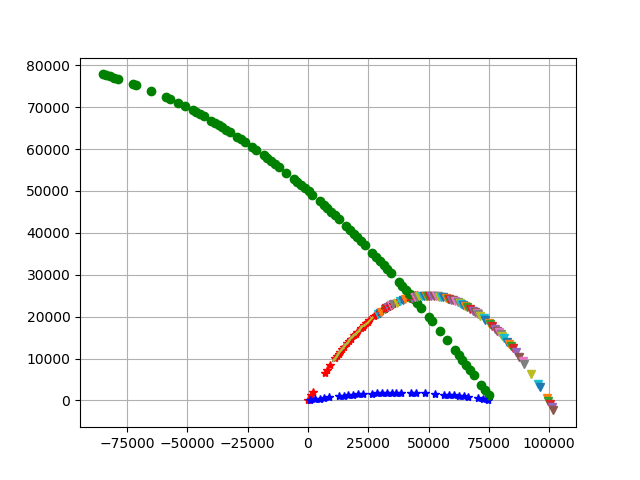

In [98]:
dt = np.arange(0, c[0]+10, 0.001)
min_dist = np.sqrt(min((x(c[0]-T0+dt,c[1],C,-u0_)-x(c[0]+dt, alpha,0, u0))**2 + (y(c[0]-T0+dt,c[1],0,u0_)-y(c[0]+dt, alpha,0, u0))**2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
def plotter(t):
    #ax.clear()
    if t < c[0]+3:
        ax.plot(x(t), y(t), 'r*')
    if(T1 < t < T0):
        ax.plot(xe[:min(int(t)-T1, T0+1-T1)], ye[:min(int(t)-T1, T0+1-T1)],'-')
    if T0 < t and y(t-T0,alpha_,0,u0_) > 0:
        ax.plot(x(t-T0,alpha_,C,-u0_), y(t-T0,alpha_,0,u0_),'b*')
    if T0 < t < c[0] or (T0 <t and min_dist > 100):
        ax.plot( x(t-T0, c[1],C,-u0_), y(t-T0, c[1], 0, u0_), 'go')
        ax.plot(x(t, alpha,0, u0), koef[0,0]*x(t)**2 + koef[1,0]*x(t) + koef[2,0], 'v') 


Полное время полета: {{round(flight_time, 5)}}

Максимальное отклонение наблюдений от реальной траектории {{round(max(abs(y(te) - ye)), 5)}}

Время перехвата: {{round(c[0], 5)}}

Угол запуска ракеты перехватчика {{round(c[1]*180/pi, 5)}}

Минимальное расстояние перехватчик - ракета {{round(min_dist, 5)}}

Угол запуска ракеты возмездия {{round(alpha_*180/pi, 5)}}

Точность ракеты возмездия {{round(abs(x0), 5)}}

In [99]:
interact(plotter, t=widgets.FloatSlider(min=0,max=flight_time,step=1,value=0,width='500px'));

interactive(children=(FloatSlider(value=0.0, description='t', max=144.20964981651179, step=1.0), Output()), _d…

## Результат моделирования                 